# Harmonic Pattern Detection

I have adopted some of the codes from

https://github.com/neurotrader888/TechnicalAnalysisAutomation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from directional_change import get_extremes
from dataclasses import dataclass
from typing import Union
from math import log
import yfinance as yf
import datetime as dt

In [ ]:

end = dt.datetime.utcnow()
start = end - dt.timedelta(days=729)   # must be ≤ 730 days for hourly data

df = yf.download(
    "BTC-USD",
    interval="1h",
    start=start,
    end=end
)

df.to_csv('./data/btc_hourly.csv')

df = yf.download(
    "BTC-USD",
    interval="1d",
    start="2010-01-01"   # earlier than BTC trading; Yahoo returns all available data
)

df.to_csv('./data/btc_daily.csv')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
@dataclass
class XABCD:
    XA_AB: Union[float, list, None]
    AB_BC: Union[float, list, None]
    BC_CD: Union[float, list, None]
    XA_AD: Union[float, list, None]
    name: str

# Define Patterns
GARTLEY = XABCD(0.618, [0.382, 0.886], [1.13, 1.618], 0.786, "Gartley")
BAT = XABCD([0.382, 0.50], [0.382, 0.886], [1.618, 2.618], 0.886, "Bat")
ALT_BAT = XABCD(0.382, [0.382, 0.886], [2.0, 3.618], 1.13, "Alt Bat")
BUTTERFLY = XABCD(0.786, [0.382, 0.886], [1.618, 2.24], [1.27, 1.41], "Butterfly")
CRAB = XABCD([0.382, 0.618], [0.382, 0.886], [2.618, 3.618], 1.618, "Crab")
DEEP_CRAB = XABCD(0.886, [0.382, 0.886], [2.0, 3.618], 1.618, "Deep Crab")
CYPHER = XABCD([0.382, 0.618], [1.13, 1.41], [1.27, 2.00], 0.786, "Cypher")
SHARK = XABCD(None, [1.13, 1.618], [1.618, 2.24], [0.886, 1.13], "Shark")

# Additional patterns can be defined and added in this list
ALL_PATTERNS = [GARTLEY, BAT, BUTTERFLY, CRAB, CYPHER, SHARK]

In [5]:
@dataclass
class XABCDFound:
    X: int
    A: int
    B: int
    C: int
    D: int # Index of last point in pattern, the entry is on the close of D
    error: float # Error found
    name: str
    bull: bool

In [6]:
def plot_pattern(ohlc: pd.DataFrame, pat: XABCDFound, inv:float, pad=3):
    """
    Display take-profit (TP) and stop-loss (SL) levels for detected harmonic pattern.

    Parameters
    ----------
    ohlc : pd.DataFrame
        Price data containing 'open', 'high', 'low', and 'close' columns.
    pat : XABCDFound
        Detected harmonic pattern object with coordinates or price levels.
    inv : float
        Total investment. Is used to calculate profit/loss value after the trade.
    pad : int
        Padding bars.

    Returns
    -------
    Python tuple
        (stop, tp1_hit, tp2_hit, inv)

        stop : bool
            if the stop level is hit.
        tp1_hit : bool
            if the first take profit level is hit.
        tp2_hit : bool
            if the second take profit level is hit.
        inv : float
            total invesment after taking this trade.
    """
    idx = ohlc.index
    
    plt.style.use('dark_background')
    fig = plt.gcf()
    ax = fig.gca()

    result_index = pat.D

    data = ohlc.iloc[max(pat.X - pad, 0): result_index+1]

    if pat.bull:
        s1 = ohlc['low'].to_numpy()
        s2 = ohlc['high'].to_numpy()
    else:
        s2 = ohlc['low'].to_numpy()
        s1 = ohlc['high'].to_numpy()
        

    l0 = [(idx[pat.X], s1[pat.X]), (idx[pat.A], s2[pat.A])]
    l1 = [(idx[pat.A], s2[pat.A]), (idx[pat.B], s1[pat.B])]
    l2 = [(idx[pat.B], s1[pat.B]), (idx[pat.C], s2[pat.C])]
    l3 = [(idx[pat.C], s2[pat.C]), (idx[pat.D], s1[pat.D])]
    
    # Connecting lines
    l4 = [(idx[pat.A], s2[pat.A]), (idx[pat.C], s2[pat.C])]
    l5 = [(idx[pat.B], s1[pat.B]), (idx[pat.D], s1[pat.D])]
    l6 = [(idx[pat.X], s1[pat.X]), (idx[pat.B], s1[pat.B])]
    l7 = [(idx[pat.X], s1[pat.X]), (idx[pat.D], s1[pat.D])]


    mpf.plot(
        data, 
        alines=dict(alines=[l0, l1, l2, l3, l4, l5, l6, l7], colors=['w', 'w', 'w', 'w', 'b', 'b', 'b', 'b', 'r', 'g', 'g']),
        type='candle', style='charles', ax=ax
    )
    
    # Text
    xa_ab =  abs(s2[pat.A] - s1[pat.B]) / abs(s1[pat.X] - s2[pat.A])
    ab_bc =  abs(s1[pat.B] - s2[pat.C]) / abs(s2[pat.A] - s1[pat.B])
    bc_cd =  abs(s2[pat.C] - s1[pat.D]) / abs(s1[pat.B] - s2[pat.C])
    xa_ad =  abs(s2[pat.A] - s1[pat.D]) / abs(s1[pat.X] - s2[pat.A])
    ax.text(int((pat.X + pat.B) / 2) - pat.X + pad, (s1[pat.X] + s1[pat.B]) / 2 , str(round(xa_ab, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.A + pat.C) / 2) - pat.X + pad, (s2[pat.A] + s2[pat.C]) / 2 , str(round(ab_bc, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.B + pat.D) / 2) - pat.X + pad, (s1[pat.B] + s1[pat.D]) / 2 , str(round(bc_cd, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.X + pat.D) / 2) - pat.X + pad, (s1[pat.X] + s1[pat.D]) / 2 , str(round(xa_ad, 3)), color='orange', fontsize='x-large')
    
    desc_string = pat.name
    desc_string += "\nError: " + str(round(pat.error , 5))
    if pat.bull:
        plt_price = data['high'].max() - 0.05 * (data['high'].max() - data['low'].min())
    else:
        plt_price = data['low'].min() + 0.05 * (data['high'].max() - data['low'].min())
    ax.text(0, plt_price , desc_string, color='yellow', fontsize='x-large')
    
    # Uncomment these lines to see predicted harmonic patterns
    #print('--'*15)
    plt.show()

In [7]:
def get_error(actual_ratio: float, pattern_ratio: Union[float, list, None]):
    """
    Compare the legs of the pattern with ideal ratios.

    Parameters
    ----------
    actual_ratio : float
        The price data to compare with the ideal
    pattern_ratio : Union[float, list, None]
        Ideal harmonic pattern ratios

    Returns
    -------
    float
        The error between given price leg and the ideal ratio.
    """     
    if pattern_ratio is None: # No requirement (Shark)
        return 0.0

    if actual_ratio != 0:
        log_actual = log(actual_ratio)
    else: 
        log_actual = -10 # just to test, normally there should be error checking -bbb

    if isinstance(pattern_ratio, list): # Acceptable range
        log_pat0 = log(pattern_ratio[0])
        log_pat1 = log(pattern_ratio[1])
        assert(log_pat1 > log_pat0)

        if log_pat0 <= log_actual <= log_pat1:
            return 0.0
        #else:
        #    return 1e20

        err = min( abs(log_actual - log_pat0), abs(log_actual - log_pat1) )
        range_mult = 2.0 # Since range is already more lenient, punish harder. 
        err *= range_mult
        return err

    elif isinstance(pattern_ratio, float):
        err = abs(log_actual - log(pattern_ratio))
        return err
    else:
        raise TypeError("Invalid pattern ratio type")

In [21]:
def find_xabcd(ohlc: pd.DataFrame, extremes: pd.DataFrame, err_thresh: float = 0.2, name = 'patterns'):
    """
    Find defined patterns in given price data.

    Parameters
    ----------
    ohlc : pd.DataFrame
        Price data containing 'open', 'high', 'low', and 'close' columns.
    extremes : pd.DataFrame
        Top and bottom points found by any algorithm (directional change in this case)

    Returns
    -------
    float
        The error between given price leg and the ideal ratio.
    """        
    extremes['seg_height'] = (extremes['ext_p'] - extremes['ext_p'].shift(1)).abs()
    extremes['retrace_ratio'] = extremes['seg_height'] / extremes['seg_height'].shift(1) 
    
    ohlc['pattern'] = 'no-pattern'
    pattern_count = dict()
    num_patterns_found = 0

    for pat in ALL_PATTERNS:
        pat_data = {}
        pat_data['bull_signal'] = np.zeros(len(ohlc))
        pat_data['bull_patterns'] = []
        pat_data['bear_signal'] = np.zeros(len(ohlc))
        pat_data['bear_patterns'] = []
    
    first_conf = extremes.index[0]
    extreme_i = 0

    for i in range(first_conf, len(ohlc)):
        
        if extremes.index[extreme_i + 1] == i:
            extreme_i += 1
        
        if extreme_i + 1 >= len(extremes):
            break
        
        if extreme_i < 3:
            continue

        ext_type = extremes.iloc[extreme_i]['type']
        last_conf_i = extremes.index[extreme_i]

        #print(last_conf_i, '    ', i)
        if extremes.iloc[extreme_i]['type'] > 0.0:  
            # Last extreme was a top, meaning we're on a leg down currently.
            # We are checking for bull patterns
            D_price = ohlc.iloc[i]['low']
            # Check that the current low is the lowest since last confirmed top 
            
            if ohlc.iloc[last_conf_i:i]['low'].min() < D_price:
                continue
        else:
            # Last extreme was a bottom, meaning we're on a leg up currently.
            # We are checking for bear patterns
            D_price = ohlc.iloc[i]['high']
            # Check that the current high is the highest since last confirmed bottom 
            if ohlc.iloc[last_conf_i:i]['high'].max() > D_price:
                continue
        

        # D_Price set, get ratios
        dc_retrace = abs(D_price - extremes.iloc[extreme_i]['ext_p']) / extremes.iloc[extreme_i]['seg_height'] 
        xa_ad_retrace = abs(D_price - extremes.iloc[extreme_i - 2]['ext_p']) / extremes.iloc[extreme_i - 2]['seg_height']
        
        best_err = 1e30
        best_pat = ""
        for pat in ALL_PATTERNS:
            err = 0.0
            err += get_error(extremes.iloc[extreme_i]['retrace_ratio'], pat.AB_BC)
            err += get_error(extremes.iloc[extreme_i - 1]['retrace_ratio'], pat.XA_AB)
            err += get_error(dc_retrace, pat.BC_CD)
            err += get_error(xa_ad_retrace, pat.XA_AD)

            err /= 4

            if err < best_err:
                best_err = err
                best_pat = pat.name
        
        if best_err <= err_thresh:
            pattern_data = XABCDFound(
                    int(extremes.iloc[extreme_i - 3]['ext_i']), 
                    int(extremes.iloc[extreme_i - 2]['ext_i']), 
                    int(extremes.iloc[extreme_i - 1]['ext_i']), 
                    int(extremes.iloc[extreme_i]['ext_i']), 
                    i, 
                    best_err, best_pat, True
            )

            if ext_type > 0.0:
                pattern_data.name = "Bull" + pattern_data.name
                pattern_data.bull = True
            else:
                pattern_data.name = "Bear" + pattern_data.name
                pattern_data.bull = False
            
            ohlc.iloc[pattern_data.X: pattern_data.D, ohlc.columns.get_loc('pattern')] = pattern_data.name

            if pattern_data.name in pattern_count.keys():
                pattern_count[pattern_data.name] += 1
            else:
                pattern_count[pattern_data.name] = 1
            
            num_patterns_found += 1
    ohlc.to_csv(f'{name}.csv')
    print('amount of patterns: ', num_patterns_found)
    print(pattern_count)
    

### 1 minute

In [25]:
if __name__ == '__main__':
    data = pd.read_csv('./data/btc_1minute_2012.csv')
    
    data['date'] = pd.to_datetime(data['date'], utc=True)
    data['date'] = data['date'].dt.tz_localize(None)

    data = data.set_index('date')

    data['r'] = np.log(data['close']).diff().shift(-1) # type: ignore
    all_combined = np.zeros(len(data))
    sigmas = [0.001, 0.002, 0.005, 0.01] # you can combine multiple sigma values here.
    for sigma in sigmas:
        print('sigma value: ', sigma)
        extremes = get_extremes(data, sigma)
        find_xabcd(data, extremes, 0.15, f'1minute_sigma{sigma}') # you can try different err_treshold values here. 
        print("--"*15)

sigma value:  0.001
amount of patterns:  552297
{'BearShark': 50978, 'BullGartley': 76966, 'BullButterfly': 57914, 'BullShark': 46053, 'BearGartley': 91372, 'BullCypher': 31723, 'BearButterfly': 69808, 'BullBat': 27152, 'BearCypher': 31869, 'BullCrab': 19612, 'BearBat': 28336, 'BearCrab': 20514}
------------------------------
sigma value:  0.002
amount of patterns:  420748
{'BearShark': 39674, 'BullGartley': 60696, 'BullButterfly': 42620, 'BullShark': 33230, 'BearGartley': 75073, 'BullCypher': 25532, 'BearButterfly': 55647, 'BullBat': 17857, 'BearCypher': 25699, 'BullCrab': 11761, 'BearBat': 19849, 'BearCrab': 13110}
------------------------------
sigma value:  0.005
amount of patterns:  231475
{'BearShark': 24246, 'BullGartley': 33255, 'BullButterfly': 21619, 'BullShark': 16833, 'BearGartley': 43767, 'BullCypher': 13915, 'BearButterfly': 33017, 'BullBat': 7496, 'BearCypher': 16543, 'BullCrab': 5095, 'BearBat': 9333, 'BearCrab': 6356}
------------------------------
sigma value:  0.01
a

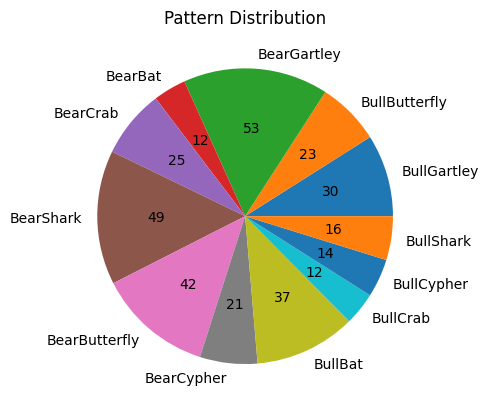

In [ ]:
pats = {'BullGartley': 30, 'BullButterfly': 23, 'BearGartley': 53, 'BearBat': 12, 'BearCrab': 25, 'BearShark': 49, 'BearButterfly': 42, 'BearCypher': 21, 'BullBat': 37, 'BullCrab': 12, 'BullCypher': 14, 'BullShark': 16}

labels = list(pats.keys())
sizes = list(pats.values())

def show_value(pct):
    total = sum(sizes)
    val = int(round(pct * total / 100))
    return f"{val}"

plt.figure()
plt.pie(sizes, labels=labels, autopct=show_value)
plt.title("Pattern Distribution")
plt.show()

In [23]:
data = {'BullGartley': 30, 'BullButterfly': 23, 'BearGartley': 53, 'BearBat': 12,
        'BearCrab': 25, 'BearShark': 49, 'BearButterfly': 42, 'BearCypher': 21,
        'BullBat': 37, 'BullCrab': 12, 'BullCypher': 14, 'BullShark': 16}

# sort by values (descending)
sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=True))

# convert to DataFrame
df = pd.DataFrame(list(sorted_data.items()), columns=['Pattern', 'Value'])

# export to CSV
df.to_csv('sorted_patterns.csv', index=False)


### 1 hour

In [22]:
if __name__ == '__main__':
    data = pd.read_csv('./data/btc_1hour_2012.csv')
    
    data['date'] = pd.to_datetime(data['date'], utc=True)
    data['date'] = data['date'].dt.tz_localize(None)

    data = data.set_index('date')

    data['r'] = np.log(data['close']).diff().shift(-1) # type: ignore
    all_combined = np.zeros(len(data))
    sigmas = [0.005, 0.01, 0.02, 0.05] # you can combine multiple sigma values here.
    for sigma in sigmas:
        print('sigma value: ', sigma)
        extremes = get_extremes(data, sigma)
        find_xabcd(data, extremes, 0.15, f'1hour_sigma{sigma}') # you can try different err_treshold values here. 
        print("--"*15)

sigma value:  0.005
amount of patterns:  11923
{'BullButterfly': 1191, 'BullGartley': 1736, 'BullShark': 744, 'BearGartley': 2175, 'BearButterfly': 1623, 'BullCypher': 675, 'BearShark': 913, 'BullBat': 675, 'BearCypher': 783, 'BullCrab': 462, 'BearBat': 527, 'BearCrab': 419}
------------------------------
sigma value:  0.01
amount of patterns:  8112
{'BullCypher': 480, 'BullButterfly': 795, 'BullGartley': 1104, 'BearGartley': 1493, 'BearButterfly': 1169, 'BearShark': 671, 'BullShark': 482, 'BullBat': 395, 'BearCypher': 601, 'BullCrab': 244, 'BearBat': 376, 'BearCrab': 302}
------------------------------
sigma value:  0.02
amount of patterns:  5011
{'BullCypher': 305, 'BullButterfly': 454, 'BullGartley': 625, 'BearGartley': 869, 'BearButterfly': 747, 'BearShark': 514, 'BullShark': 331, 'BearCypher': 412, 'BearCrab': 191, 'BullCrab': 128, 'BullBat': 190, 'BearBat': 245}
------------------------------
sigma value:  0.05
amount of patterns:  2239
{'BullCypher': 95, 'BullButterfly': 211, 'B

### 4 hours

In [23]:
if __name__ == '__main__':
    data = pd.read_csv('./data/btc_4hour_2012.csv')
    
    data['date'] = pd.to_datetime(data['date'], utc=True)
    data['date'] = data['date'].dt.tz_localize(None)

    data = data.set_index('date')

    data['r'] = np.log(data['close']).diff().shift(-1) # type: ignore
    all_combined = np.zeros(len(data))
    sigmas = [0.005, 0.01, 0.02, 0.05] # you can combine multiple sigma values here.
    for sigma in sigmas:
        print('sigma value: ', sigma)
        extremes = get_extremes(data, sigma)
        find_xabcd(data, extremes, 0.15, f'4hours_sigma{sigma}') # you can try different err_treshold values here. 
        print("--"*15)

sigma value:  0.005
amount of patterns:  3440
{'BullButterfly': 340, 'BullShark': 221, 'BearButterfly': 463, 'BullGartley': 446, 'BearShark': 264, 'BearGartley': 641, 'BearCypher': 224, 'BearCrab': 123, 'BullBat': 215, 'BullCrab': 142, 'BullCypher': 201, 'BearBat': 160}
------------------------------
sigma value:  0.01
amount of patterns:  2914
{'BullCypher': 182, 'BullButterfly': 291, 'BearGartley': 524, 'BearButterfly': 397, 'BullGartley': 382, 'BearShark': 217, 'BullShark': 194, 'BearCypher': 205, 'BearCrab': 122, 'BullCrab': 108, 'BullBat': 160, 'BearBat': 132}
------------------------------
sigma value:  0.02
amount of patterns:  2191
{'BullCypher': 117, 'BullButterfly': 188, 'BearGartley': 386, 'BearButterfly': 339, 'BullShark': 154, 'BullGartley': 267, 'BearCypher': 167, 'BearShark': 185, 'BearBat': 118, 'BearCrab': 92, 'BullBat': 108, 'BullCrab': 70}
------------------------------
sigma value:  0.05
amount of patterns:  1142
{'BullCypher': 63, 'BearGartley': 238, 'BullShark': 5

### 1 day

In [24]:
if __name__ == '__main__':
    data = pd.read_csv('./data/btc_1hour_2012.csv')
    
    data['date'] = pd.to_datetime(data['date'], utc=True)
    data['date'] = data['date'].dt.tz_localize(None)

    data = data.set_index('date')

    data['r'] = np.log(data['close']).diff().shift(-1) # type: ignore
    all_combined = np.zeros(len(data))
    sigmas = [0.01, 0.02, 0.05, 0.07, 0.1] # you can combine multiple sigma values here.
    for sigma in sigmas:
        print('sigma value: ', sigma)
        extremes = get_extremes(data, sigma)
        find_xabcd(data, extremes, 0.15, f'1day_sigma{sigma}') # you can try different err_treshold values here. 
        print("--"*15)

sigma value:  0.01
amount of patterns:  8112
{'BullCypher': 480, 'BullButterfly': 795, 'BullGartley': 1104, 'BearGartley': 1493, 'BearButterfly': 1169, 'BearShark': 671, 'BullShark': 482, 'BullBat': 395, 'BearCypher': 601, 'BullCrab': 244, 'BearBat': 376, 'BearCrab': 302}
------------------------------
sigma value:  0.02
amount of patterns:  5011
{'BullCypher': 305, 'BullButterfly': 454, 'BullGartley': 625, 'BearGartley': 869, 'BearButterfly': 747, 'BearShark': 514, 'BullShark': 331, 'BearCypher': 412, 'BearCrab': 191, 'BullCrab': 128, 'BullBat': 190, 'BearBat': 245}
------------------------------
sigma value:  0.05
amount of patterns:  2239
{'BullCypher': 95, 'BullButterfly': 211, 'BearShark': 237, 'BullGartley': 317, 'BearGartley': 412, 'BearButterfly': 427, 'BullBat': 113, 'BullShark': 92, 'BullCrab': 49, 'BearBat': 78, 'BearCrab': 74, 'BearCypher': 134}
------------------------------
sigma value:  0.07
amount of patterns:  1917
{'BullGartley': 253, 'BearShark': 207, 'BearButterfly'